Nama : Devaldi Caliesta Octadiani \
Email : devaldicaliesta20@gmail.com \
Alamat Domisili : Kabupaten Bantul, Daerah Istimewa Yogyakarta, 55187


In [ ]:
# Menyiapkan Library yang dibutuhkan
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
# melihat dataset
df = pd.read_csv('bbc-news-data.csv', sep="\t") 
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
# melihat info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
# melihat missing value
df.isna().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [ ]:
# Drop data yang tidak dibutuhkan
df_new = df.drop(['filename'], axis=1)

df_new.head()

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
# menghilangkan tanda baca & angka pada coloumn content
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


df_new['content'] = df['content'].apply(remove_punctuations_numbers)

In [ ]:
def data_cleaner(review):
   #removing stop words
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])

    return review

ps = PorterStemmer()
stop_words = stopwords.words('english')

df_new['content'] = df_new['content'].apply(data_cleaner)

In [ ]:
# mengecek data yang telah di prepocessing
df_new.head()

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits US media giant TimeWarner ju...
1,business,Dollar gains on Greenspan speech,The dollar hit highest level euro almost three...
2,business,Yukos unit buyer faces loan claim,The owners embattled Russian oil giant Yukos a...
3,business,High fuel prices hit BA's profits,British Airways blamed high fuel prices drop p...
4,business,Pernod takeover talk lifts Domecq,Shares UK drinks food firm Allied Domecq risen...


In [ ]:
# melakukan split data
news = list(df.content)
label = list(df.category)

In [ ]:
#bagi data untuk training dan data untuk testing.
news_train, news_test, label_train, label_test = train_test_split(news, label, train_size = 0.8, random_state = 42, shuffle = True)

In [ ]:
vocab_size = 10000
embedding_dim = 32
max_length = 256
padding_type='post'

In [ ]:
# melakukan tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(news_train)
word_index = tokenizer.word_index

news_train_sqncs = tokenizer.texts_to_sequences(news_train)
news_train_padded = pad_sequences(news_train_sqncs, padding=padding_type, maxlen=max_length)

news_test_sqncs = tokenizer.texts_to_sequences(news_test)
news_test_padded = pad_sequences(news_test_sqncs, padding=padding_type, maxlen=max_length)

category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(df.category)
category_index = category_tokenizer.word_index

label_train_label_sqncs = np.array(category_tokenizer.texts_to_sequences(y_train))
label_test_label_sqncs = np.array(category_tokenizer.texts_to_sequences(y_test))

In [ ]:
# melakukan arsitektur model kita menggunakan layer Embedding
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 324,998
Trainable params: 324,998
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# melatih model kita dengan memanggil fungsi fit() dan menggunakan callback earlystopping

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,
                                                  restore_best_weights=True)

num_epochs = 50
history = model.fit(news_train_padded, label_train_label_sqncs, epochs=num_epochs, 
                    validation_data=(news_test_padded, label_test_label_sqncs), 
                    verbose=2, callbacks=[callbacks], batch_size=32)

Epoch 1/50
56/56 - 1s - loss: 1.7288 - accuracy: 0.2781 - val_loss: 1.6331 - val_accuracy: 0.2921
Epoch 2/50
56/56 - 0s - loss: 1.5369 - accuracy: 0.4017 - val_loss: 1.4075 - val_accuracy: 0.4697
Epoch 3/50
56/56 - 0s - loss: 1.2135 - accuracy: 0.6174 - val_loss: 1.0318 - val_accuracy: 0.7326
Epoch 4/50
56/56 - 0s - loss: 0.7778 - accuracy: 0.8579 - val_loss: 0.6537 - val_accuracy: 0.8966
Epoch 5/50
56/56 - 0s - loss: 0.4243 - accuracy: 0.9607 - val_loss: 0.4093 - val_accuracy: 0.9258
Epoch 6/50
56/56 - 0s - loss: 0.2377 - accuracy: 0.9708 - val_loss: 0.2968 - val_accuracy: 0.9236
Epoch 7/50
56/56 - 0s - loss: 0.1441 - accuracy: 0.9809 - val_loss: 0.2402 - val_accuracy: 0.9371
Epoch 8/50
56/56 - 0s - loss: 0.0946 - accuracy: 0.9916 - val_loss: 0.2064 - val_accuracy: 0.9528
Epoch 9/50
56/56 - 0s - loss: 0.0649 - accuracy: 0.9944 - val_loss: 0.1842 - val_accuracy: 0.9483
Epoch 10/50
56/56 - 0s - loss: 0.0461 - accuracy: 0.9978 - val_loss: 0.1765 - val_accuracy: 0.9506
Epoch 11/50
56/56 -

Text(0.5, 1.0, 'Train and Validation Loss Graphs')

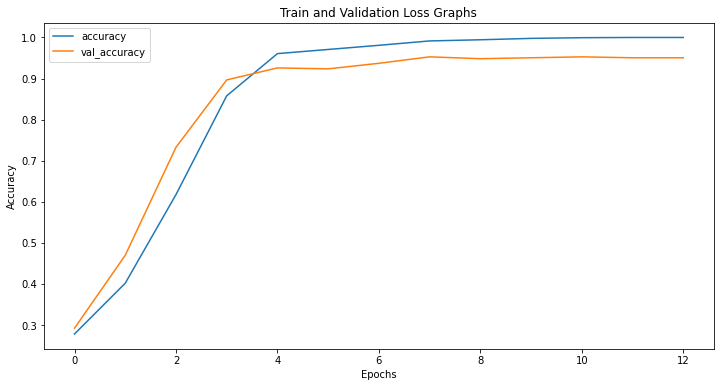

In [ ]:
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Train and Validation Loss Graphs')

Text(0.5, 1.0, 'Train and Validation Accuracy Graphs')

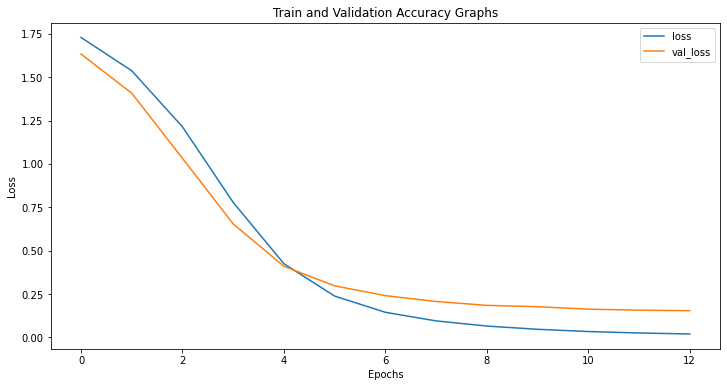

In [ ]:
#plot loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.title('Train and Validation Accuracy Graphs')